In [15]:
!pip3 install torch torchvision scikit-learn
 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import numpy as np
import time

print("PyTorch:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch: 2.9.1+cu130
Using device: cuda


In [17]:
# Initial transform: resize + tensor only
base_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_raw = torchvision.datasets.STL10(
    root="./data",
    split="train",
    download=True,
    transform=base_transform
)

print("Train size:", len(train_raw))  # should be 5000

# Compute mean and std over training data
loader_tmp = DataLoader(train_raw, batch_size=256, shuffle=False)

mean = 0.0
std = 0.0
n_samples = 0

for imgs, _ in loader_tmp:
    batch_size = imgs.size(0)
    imgs = imgs.view(batch_size, imgs.size(1), -1)  # (B, C, H*W)
    mean += imgs.mean(2).sum(0)
    std  += imgs.std(2).sum(0)
    n_samples += batch_size

mean /= n_samples
std /= n_samples

print("Mean:", mean)
print("Std:", std)

Train size: 5000
Mean: tensor([0.4468, 0.4399, 0.4068])
Std: tensor([0.2027, 0.2003, 0.2028])


In [18]:
# Final transform with normalization to zero-mean, unit-variance
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_full = torchvision.datasets.STL10(
    root="./data",
    split="train",
    download=False,
    transform=transform
)

test_full = torchvision.datasets.STL10(
    root="./data",
    split="test",
    download=False,
    transform=transform
)

print("Train size:", len(train_full))  # 5000
print("Test size:", len(test_full))    # 8000

# Split test_full -> 300 val, 500 test, rest unused
n_total_test = len(test_full)
assert n_total_test == 8000

val_size = 300
test_size = 500
remainder = n_total_test - (val_size + test_size)  # 7200

val_subset, test_subset, _ = random_split(
    test_full,
    [val_size, test_size, remainder]
)

print("Val size:", len(val_subset))
print("Final test size:", len(test_subset))

# Dataloaders
BATCH_SIZE = 128

train_loader = DataLoader(train_full, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

Train size: 5000
Test size: 8000
Val size: 300
Final test size: 500


In [19]:
class LeNet5_Enhanced(nn.Module):
    def __init__(self):
        super().__init__()
        
        # ---- Convolution Layers ----
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.bn1   = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.bn2   = nn.BatchNorm2d(16)

        self.pool  = nn.MaxPool2d(2,2)

        # ---- Dropout in feature maps ----
        self.drop_conv = nn.Dropout2d(p=0.25)

        # ---- Fully Connected Layers ----
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.fc3 = nn.Linear(84, 10)

        # Dropout on FC layers
        self.drop_fc = nn.Dropout(p=0.5)

    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Conv block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Dropout on last feature map
        x = self.drop_conv(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC block 1 with BN + Dropout
        x = self.drop_fc(F.relu(self.bn3(self.fc1(x))))

        # FC block 2 with BN + Dropout
        x = self.drop_fc(F.relu(self.bn4(self.fc2(x))))

        # Output logits
        x = self.fc3(x)
        return x

model = LeNet5_Enhanced().to(device)
print(model)

LeNet5_Enhanced(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_conv): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (drop_fc): Dropout(p=0.5, inplace=False)
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=2e-4   # L2 regularization strength (λ)
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [21]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    n = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            n += y.size(0)
    
    return total_loss / n, correct / n

In [22]:
EPOCHS = 100

train_losses = []      # per batch
val_losses = []        # one every 5 epochs
val_accuracies = []    # one every 5 epochs
val_check_epochs = []  # which epoch each val corresponds to

for epoch in range(EPOCHS):
    model.train()
    epoch_start = time.time()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        # Log training loss each batch
        train_losses.append(loss.item())
    
    # Step LR scheduler
    scheduler.step()
    
    # Validation every 5 epochs
    if (epoch + 1) % 5 == 0:
        v_loss, v_acc = evaluate(model, val_loader)
        val_losses.append(v_loss)
        val_accuracies.append(v_acc)
        val_check_epochs.append(epoch + 1)
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f} | "
              f"time: {time.time()-epoch_start:.1f}s")

Epoch   5/100 | Val Loss: 1.5805 | Val Acc: 0.4133 | LR: 0.001000 | time: 0.9s
Epoch  10/100 | Val Loss: 1.4762 | Val Acc: 0.4500 | LR: 0.001000 | time: 0.9s
Epoch  15/100 | Val Loss: 1.4319 | Val Acc: 0.4633 | LR: 0.001000 | time: 0.9s
Epoch  20/100 | Val Loss: 1.4058 | Val Acc: 0.4633 | LR: 0.000500 | time: 1.0s
Epoch  25/100 | Val Loss: 1.3585 | Val Acc: 0.4800 | LR: 0.000500 | time: 0.9s
Epoch  30/100 | Val Loss: 1.3653 | Val Acc: 0.5000 | LR: 0.000500 | time: 0.9s
Epoch  35/100 | Val Loss: 1.3550 | Val Acc: 0.4800 | LR: 0.000500 | time: 0.9s
Epoch  40/100 | Val Loss: 1.3398 | Val Acc: 0.5033 | LR: 0.000250 | time: 1.0s
Epoch  45/100 | Val Loss: 1.3311 | Val Acc: 0.5000 | LR: 0.000250 | time: 0.9s
Epoch  50/100 | Val Loss: 1.3319 | Val Acc: 0.4900 | LR: 0.000250 | time: 0.9s
Epoch  55/100 | Val Loss: 1.3221 | Val Acc: 0.5000 | LR: 0.000250 | time: 0.9s
Epoch  60/100 | Val Loss: 1.3434 | Val Acc: 0.5033 | LR: 0.000125 | time: 0.9s
Epoch  65/100 | Val Loss: 1.3241 | Val Acc: 0.5000 |

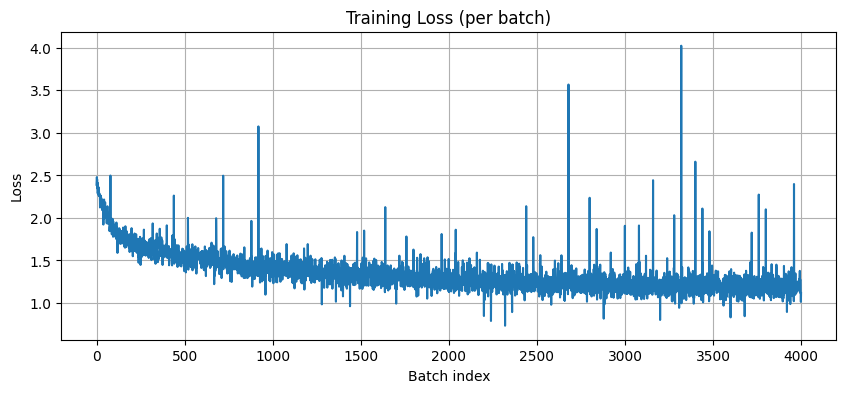

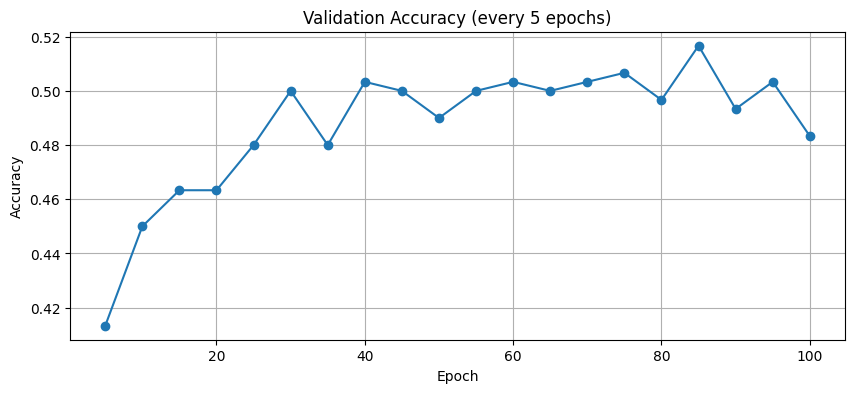

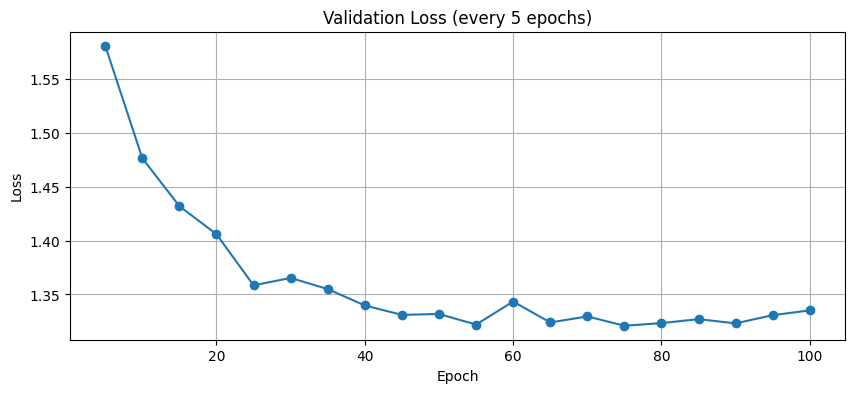

In [23]:
# Training loss per batch
plt.figure(figsize=(10,4))
plt.plot(train_losses)
plt.title("Training Loss (per batch)")
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Validation accuracy over epochs
plt.figure(figsize=(10,4))
plt.plot(val_check_epochs, val_accuracies, marker='o')
plt.title("Validation Accuracy (every 5 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Validation loss over epochs
plt.figure(figsize=(10,4))
plt.plot(val_check_epochs, val_losses, marker='o')
plt.title("Validation Loss (every 5 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [24]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 1.3554
Test accuracy: 0.4780


In [25]:
# Get all predictions and labels on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[24  3  3  0  2  0  1  0  5  0]
 [ 0 14  0  7  6  0  3  9  2  0]
 [ 1  1 33  1  0  0  1  0  5 12]
 [ 0  2  0 21  6  3  4 10  0  1]
 [ 1  1  0  5 35  1  3  4  0  0]
 [ 1  2  0 15 15  6 15 18  0  1]
 [ 0  1  0  1 10  5 34  7  0  0]
 [ 1  1  1 16  3  1  2 19  0  1]
 [ 2  2  0  0  1  0  1  0 33  1]
 [ 5  1 16  1  0  0  3  1  7 20]]


In [26]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer',
               'dog', 'horse', 'monkey', 'ship', 'truck']

class_correct = cm.diagonal()
class_totals = cm.sum(axis=1)
class_acc = class_correct / class_totals

for idx, (name, acc) in enumerate(zip(class_names, class_acc)):
    print(f"Class {idx} ({name:8s}): {acc:.3f}")

Class 0 (airplane): 0.632
Class 1 (bird    ): 0.341
Class 2 (car     ): 0.611
Class 3 (cat     ): 0.447
Class 4 (deer    ): 0.700
Class 5 (dog     ): 0.082
Class 6 (horse   ): 0.586
Class 7 (monkey  ): 0.422
Class 8 (ship    ): 0.825
Class 9 (truck   ): 0.370


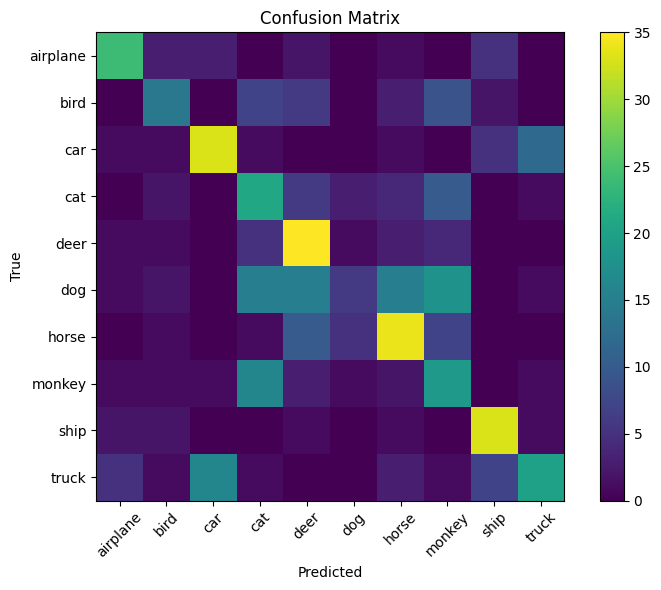

In [27]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()